# 7T PNI | MPC group difference

In [86]:
# Set the environment
import os
import glob
import numpy as np
import nibabel as nb
from nibabel.freesurfer.mghformat import load
from brainspace.plotting import plot_hemispheres
from brainspace.mesh.mesh_io import read_surface
from brainspace.datasets import load_conte69
from brainspace.gradient import GradientMaps
from brainspace.utils.parcellation import map_to_labels
from brainspace.mesh.array_operations import smooth_array
import matplotlib.pyplot as plt
from nilearn import plotting # only to plot the matrices
import scipy.stats as ss
import seaborn as sns

# CHECK seaborn color paletes:
#   https://seaborn.pydata.org/tutorial/color_palettes.html


def plot_connectome(mtx, Title='matrix plot', xlab='X', ylab='Y', col='rocket'):
    '''
    This optional function, only plots a connectome as a heatmap
    Parameters
    ----------
    mtx : np.array
    Returns
    -------
    f : plot
    '''
    f, ax = plt.subplots(figsize=(15,10))
    g = sns.heatmap(mtx, ax=ax, cmap=col)
    g.set_xlabel(xlab)
    g.set_ylabel(ylab)
    g.set_title(Title)

# Function 2
def vectorized_mtx(connectome_matrix):
    '''
    This function will: 
    a) vectorize the upper triangle
    b) convert the array into pandas dataframe 
    
    Parameters
    ----------
    connectome_matrix : np.array
    Returns
    -------
    df_feat_flat : Single column pandas dataframe of edges
    
    '''
    
    # Extract lower (or upper) triangle entrees (excluding diagonal)
    tril_idx = np.tril_indices(len(connectome_matrix),k=1) 
    features_flat = connectome_matrix[tril_idx]
    #print(f'Number of features per subject: {len(features_flat)}')
            
    return features_flat

def load_mpc(File, Ndim):
    """Loads and process a MPC"""

    # load the matrix
    mtx_mpc = nb.load(File).darrays[0].data

    # Mirror the matrix
    MPC = np.triu(mtx_mpc,1)+mtx_mpc.T

    # Remove the medial wall
    MPC = np.delete(np.delete(MPC, 0, axis=0), 0, axis=1)
    MPC = np.delete(np.delete(MPC, Ndim, axis=0), Ndim, axis=1)
    
    MPC[MPC==0] = np.finfo(float).eps

    return MPC

# Set dataset PNI as working directory
os.chdir('/data_/mica3/BIDS_PNI/derivatives/micapipe_v0.2.0')

# Load conte69
c69_lh, c69_rh = load_conte69()

# Load fsaverage5
fs5_lh = read_surface('/data_/mica3/BIDS_PNI/derivatives/fastsurfer/fsaverage5/surf/lh.pial', itype='fs')
fs5_rh = read_surface('/data_/mica3/BIDS_PNI/derivatives/fastsurfer/fsaverage5/surf/rh.pial', itype='fs')

# Variables
micapipe='/data_/mica1/01_programs/micapipe-v0.2.0'

# Here we define the atlas
atlas='glasser-360' # 'schaefer-400' 'vosdewael-400'  'aparc-a2009s' 'schaefer-400'

# Read label for conte69
labels_c69 = np.loadtxt(open(micapipe + '/parcellations/' + atlas + '_conte69.csv'), dtype=int)

# mask of the medial wall
mask_c69 = labels_c69 != 0

def smooth_surf(surf_l, surf_r, points, Kernel='uniform', Niter=20, Relax=0.5, Mask=mask_c69):
    '''
    This function smooth an array (left and right) on a given surface
    Parameters
    ----------
    surf_l : np.array left surface 
    surf_r : np.array right surface
    points : np.array surface data
    Kernel : {'uniform', 'gaussian', 'inverse_distance'}
    Niter  : int, optional NUmber of smooth iterations
    Relax  : relax : float, optional relaxation facto
    Mask   : str or 1D ndarray, optional
    Returns
    -------
    sdata : smoothed numpy array
    
    '''
    n2dim = int(Mask.shape[0]/2)
    Mask_l=mask_c69[0:n2dim]
    Mask_r=mask_c69[n2dim:Mask.shape[0]]
    sdata = np.concatenate((smooth_array(surf_l, points[0:32492],kernel=Kernel, n_iter=Niter,relax=Relax, mask=Mask_l), 
                          smooth_array(surf_r, points[32492:64984],kernel=Kernel, n_iter=Niter,relax=Relax, mask=Mask_r)), axis=0)
    return(sdata)


In [87]:
# Load annotation file in fsaverage5
annot_lh_fs5= nb.freesurfer.read_annot(micapipe + '/parcellations/lh.'+atlas+'_mics.annot')
Ndim = max(np.unique(annot_lh_fs5[0]))
annot_rh_fs5= nb.freesurfer.read_annot(micapipe + '/parcellations/rh.'+atlas+'_mics.annot')[0]+Ndim

# Load the inflated surface
inf_lh = read_surface(micapipe + '/surfaces/fsLR-32k.L.inflated.surf.gii', itype='gii')
inf_rh = read_surface(micapipe + '/surfaces/fsLR-32k.R.inflated.surf.gii', itype='gii')

# list of all files
MPC_files = sorted(glob.glob(f'sub-*/ses-01/mpc/acq-T1map/*_atlas-{atlas}_desc-MPC.shape.gii'))


In [88]:
# exclude PNC004 and PNC011
MPC_files = [item for item in MPC_files if "PNC004" not in item and "PNC011" not in item]


In [89]:
# Load all the  MPC matrices as array
MPC=np.empty([Ndim*2, Ndim*2, len(MPC_files)], dtype=float)
for i, f in enumerate(MPC_files):
    #print(f)
    MPC[:,:,i] = load_mpc(f, Ndim)

# Index of the controls
indx =np.array(["PNC" in f for f in MPC_files])

# Mean matrix across the z axis
MPChc = np.mean(MPC[:,:,indx], axis=2)
MPCpx = np.mean(MPC[:,:,~indx], axis=2)

In [132]:
# Calculate the gradients
Ngrads=3
MPC_all = np.mean(MPC, axis=2)
MPCgm = GradientMaps(n_components=Ngrads, random_state=None, approach='dm', kernel='normalized_angle')
MPCgm.fit(MPC_all, sparsity=0.9)

# Plot G1
MPC_g1 = map_to_labels(MPCgm.gradients_[:,0], labels_c69, fill=np.nan, mask=mask_c69)
plot_hemispheres(inf_lh, inf_rh, array_name=smooth_surf(inf_lh, inf_rh,MPC_g1, Niter=10), cmap='RdBu_r',
                  embed_nb=True,  label_text={'left':['G1']}, color_bar='right',
                  layout_style='grid',
                  zoom=1.3, size=(900, 700), nan_color=(0, 0, 0, 1), color_range='sym',
                  screenshot=True, filename='/home/bic/rcruces/Desktop/MPC-G1_all'+atlas+'.png') 

'/home/bic/rcruces/Desktop/MPC-G1_allglasser-360.png'

# Healthy Controls MPC gradient

In [131]:
# Plot G1
Range=(-0.2,0.2)
MPC_g1 = map_to_labels(MPCgm.gradients_[:,0], labels_c69, fill=np.nan, mask=mask_c69)
plot_hemispheres(inf_lh, inf_rh, array_name=smooth_surf(inf_lh, inf_rh,MPC_g1, Niter=10), cmap='Spectral_r',
                  embed_nb=True,  label_text={'left':['G1']}, color_bar='right',
                  layout_style='grid',
                  zoom=1.3, size=(900, 750), nan_color=(0, 0, 0, 1), color_range=Range,
                  screenshot=True, filename='/home/bic/rcruces/Desktop/MPC-G1_HC-group-mean_'+atlas+'.png') 

'/home/bic/rcruces/Desktop/MPC-G1_HC-group-mean_glasser-360.png'

# Autism MPC gradient

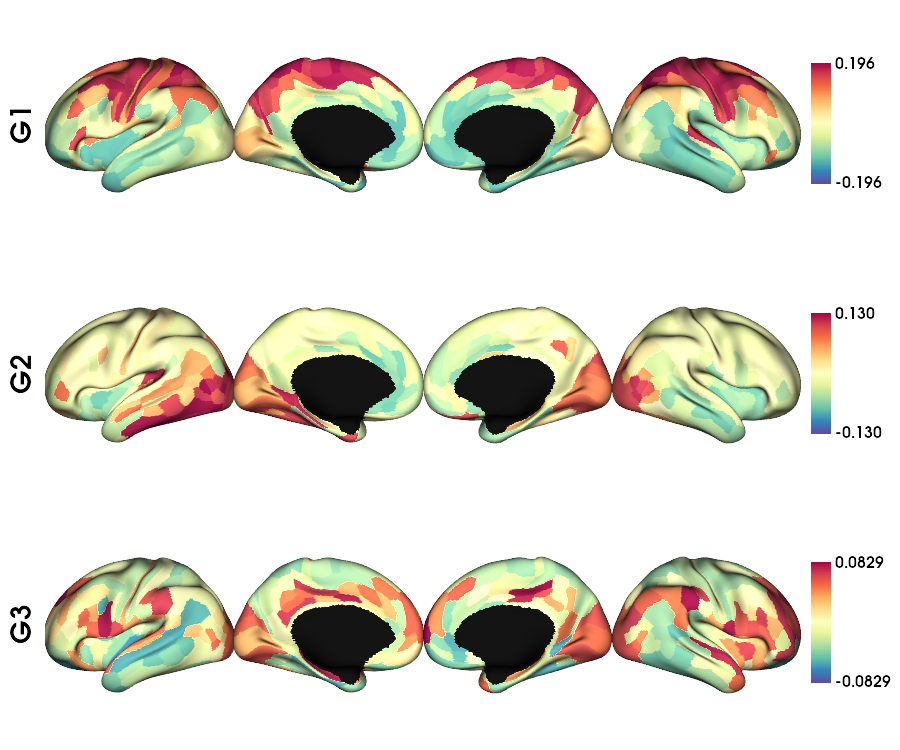

In [92]:
# Calculate the gradients
Ngrads=3
MPCpxG = GradientMaps(n_components=Ngrads, alignment='procrustes', kernel='normalized_angle')
MPCpxG.fit(MPCpx, sparsity=0.9, reference=MPCgm.gradients_)

# Map gradients to original parcels
# other color 'RdYlBu_r'
grad = [None] * Ngrads
for i, g in enumerate(MPCpxG.aligned_.T[0:Ngrads,:]):
    grad[i] = map_to_labels(g, labels_c69, fill=np.nan, mask=mask_c69)

# plot the gradients
labels=['G'+str(x) for x in list(range(1,Ngrads+1))]
plot_hemispheres(inf_lh, inf_rh, array_name=grad, cmap='Spectral_r', nan_color=(0, 0, 0, 1),
  zoom=1.3, size=(900, 750), embed_nb=True, color_range='sym',
  color_bar='right', 
  label_text={'left': labels},
  screenshot=False, filename='/home/bic/rcruces/Desktop/MPC_mean_AU_'+atlas+'.png') 

In [133]:
# Plot G1
MPC_g1 = map_to_labels(MPCpxG.gradients_[:,0], labels_c69, fill=np.nan, mask=mask_c69)
plot_hemispheres(inf_lh, inf_rh, array_name=smooth_surf(inf_lh, inf_rh,MPC_g1, Niter=10), cmap='Spectral_r',
                  embed_nb=True,  label_text={'left':['G1']}, color_bar='right',
                  layout_style='grid',
                  zoom=1.3, size=(900, 750), nan_color=(0, 0, 0, 1), color_range=Range,
                  screenshot=True, filename='/home/bic/rcruces/Desktop/MPC-G1_AUS-group-mean_'+atlas+'.png') 

'/home/bic/rcruces/Desktop/MPC-G1_AUS-group-mean_glasser-360.png'

# Alingned gradients to the Mean

In [115]:
# Empty array for the aligned gradients
# ROI x Ngradients x Subjects
MPCdm = np.empty((MPC.shape[0], Ngrads, MPC.shape[2]), dtype=float)

# Calculate and align a gradient per subject
for k, subMPC in enumerate(MPC_files):
    print(subMPC.split('/')[0].replace('sub-',''))
    # Areate gradient model
    MPCsub = GradientMaps(n_components=Ngrads, alignment='procrustes', kernel='normalized_angle')
    # Align to HC mean
    MPCsub.fit(MPC[:,:,k], sparsity=0.9, reference=MPCgm.gradients_)
    MPCdm[:,:,k] = MPCsub.aligned_
    


PNA001
PNA002
PNA003
PNA004
PNA005
PNA006
PNC001
PNC002
PNC003
PNC005
PNC006
PNC007
PNC009
PNC010
PNC012
PNC013
PNC014
PNC015
PNC016
PNC017
PNC018
PNC019


# Mean NT MPC gradients aligned

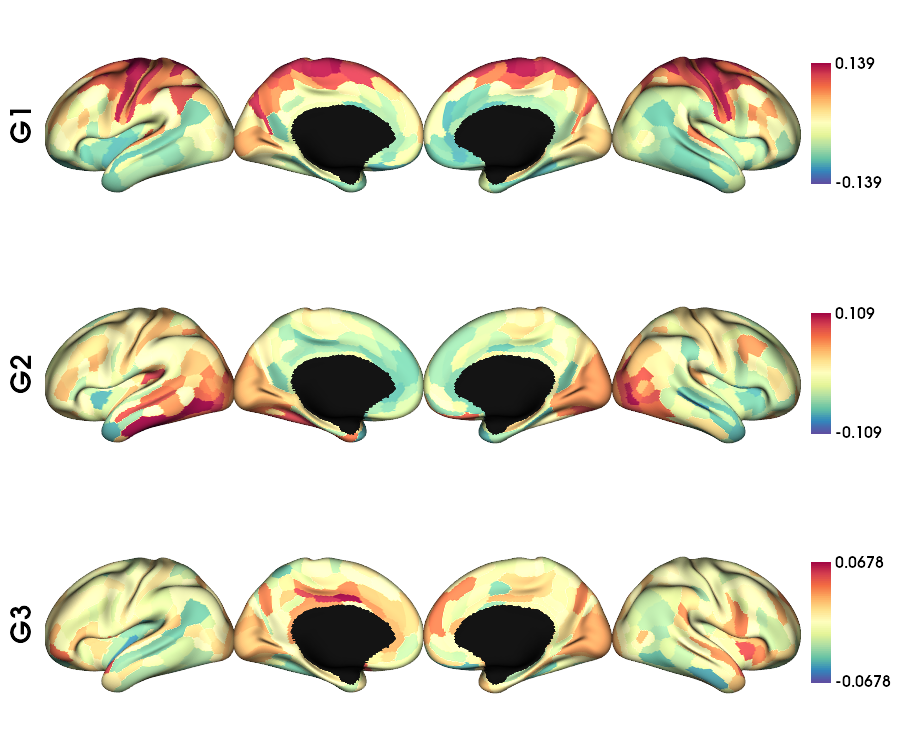

In [116]:
# Map gradients to original parcels
# other color 'RdYlBu_r'
MPC_aling_NT = np.mean(MPCdm[:,:,indx], axis=2)

grad = [None] * Ngrads
for i, g in enumerate(MPC_aling_NT.T[0:Ngrads,:]):
    grad[i] = map_to_labels(g, labels_c69, fill=np.nan, mask=mask_c69)

# plot the gradients
labels=['G'+str(x) for x in list(range(1,Ngrads+1))]
plot_hemispheres(inf_lh, inf_rh, array_name=grad, cmap='Spectral_r', nan_color=(0, 0, 0, 1),
  zoom=1.3, size=(900, 750), embed_nb=True, color_range='sym',
  color_bar='right', 
  label_text={'left': labels},
  screenshot=False, filename='/home/bic/rcruces/Desktop/MPC_mean_alinged_HC_'+atlas+'.png') 

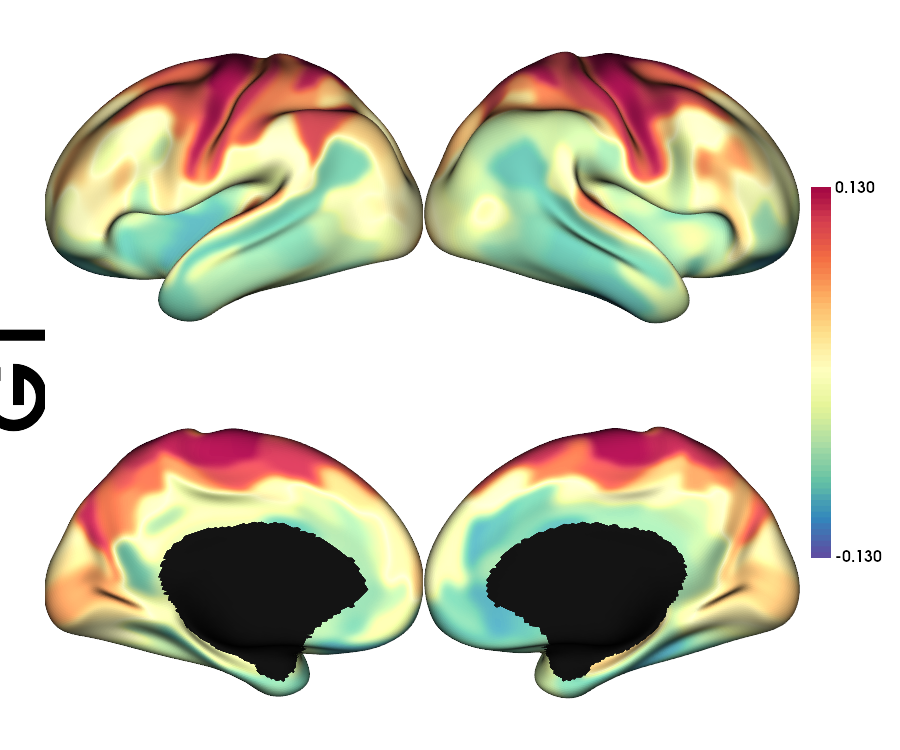

In [117]:
# Plot G1
Range=(-0.13,0.13)
MPC_g1NT = map_to_labels(MPC_aling_NT[:,0], labels_c69, fill=np.nan, mask=mask_c69)
plot_hemispheres(inf_lh, inf_rh, array_name=smooth_surf(inf_lh, inf_rh,MPC_g1NT, Niter=10), cmap='Spectral_r',
                  embed_nb=True,  label_text={'left':['G1']}, color_bar='right',
                  layout_style='grid',
                  zoom=1.3, size=(900, 750), nan_color=(0, 0, 0, 1), color_range=Range,
                  screenshot=False, filename='/home/bic/rcruces/Desktop/MPC-G1_HC-aligned-mean_'+atlas+'.png') 

# Mean AUS gradients aligned

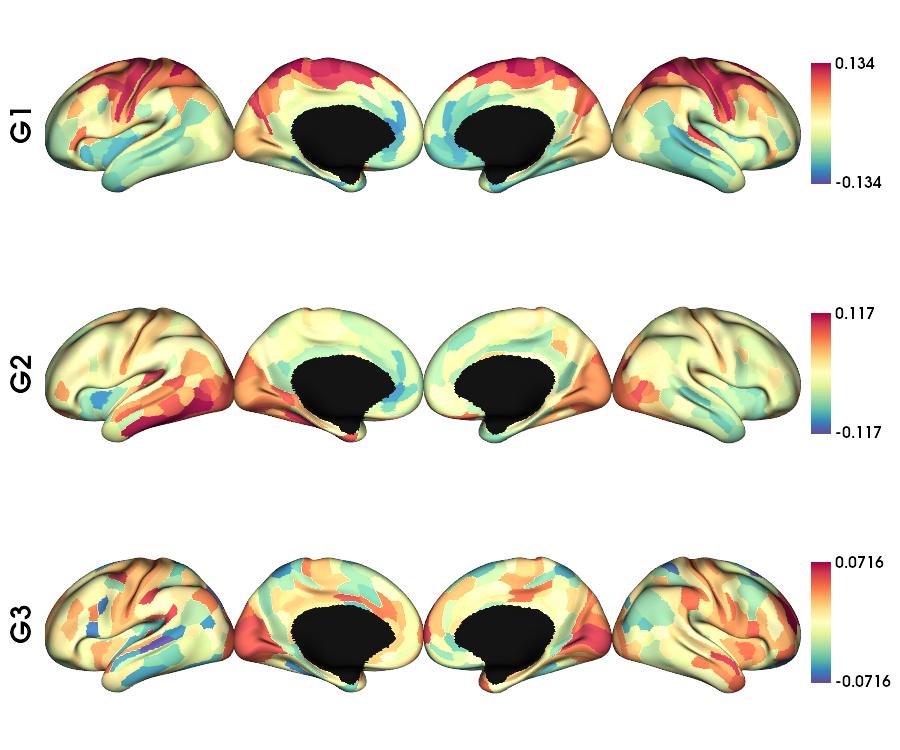

In [118]:
# Map gradients to original parcels
# other color 'RdYlBu_r'
MPC_alingAUS = np.mean(MPCdm[:,:,~indx], axis=2)

grad = [None] * Ngrads
for i, g in enumerate(MPC_alingAUS.T[0:Ngrads,:]):
    grad[i] = map_to_labels(g, labels_c69, fill=np.nan, mask=mask_c69)

# plot the gradients
labels=['G'+str(x) for x in list(range(1,Ngrads+1))]
plot_hemispheres(inf_lh, inf_rh, array_name=grad, cmap='Spectral_r', nan_color=(0, 0, 0, 1),
  zoom=1.3, size=(900, 750), embed_nb=True, color_range='sym',
  color_bar='right', 
  label_text={'left': labels},
  screenshot=False, filename='/home/bic/rcruces/Desktop/MPC_mean_alinged_AU_'+atlas+'.png')

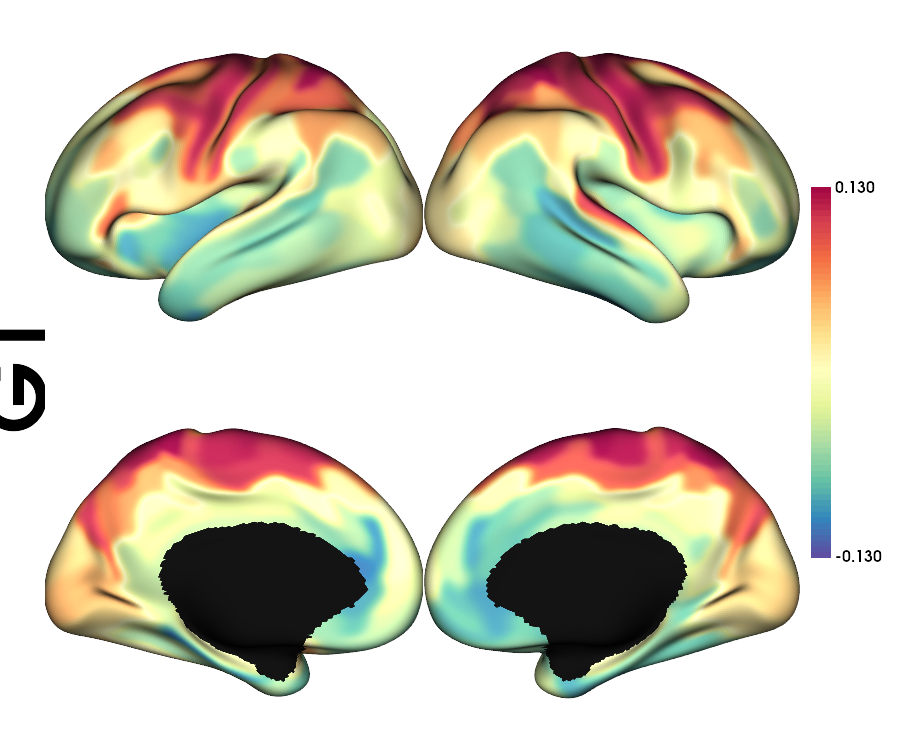

In [120]:
# Plot G1
MPC_g1 = map_to_labels(MPC_alingAUS[:,0], labels_c69, fill=np.nan, mask=mask_c69)
plot_hemispheres(inf_lh, inf_rh, array_name=smooth_surf(inf_lh, inf_rh,MPC_g1, Niter=10), cmap='Spectral_r',
                  embed_nb=True,  label_text={'left':['G1']}, color_bar='right',
                  layout_style='grid',
                  zoom=1.3, size=(900, 750), nan_color=(0, 0, 0, 1), color_range=Range,
                  screenshot=False, filename='/home/bic/rcruces/Desktop/MPC-G1_AUS-aligned-mean_'+atlas+'.png') 

# Gradients from PNA001

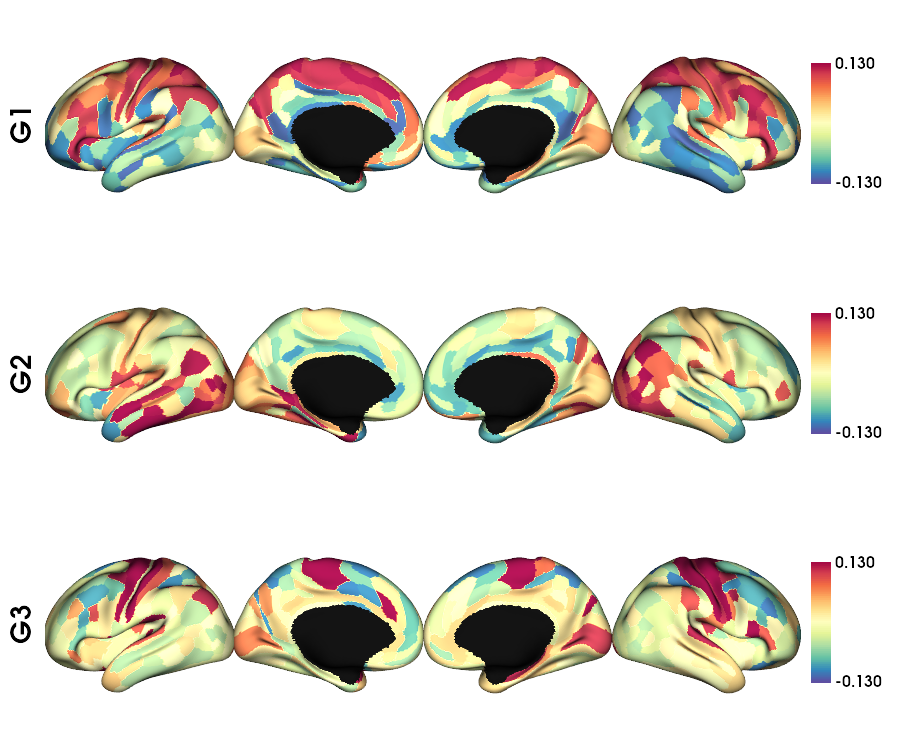

In [123]:
# Map gradients to original parcels
grad = [None] * Ngrads
for i, g in enumerate(MPCdm[:,:,0].T[0:Ngrads,:]):
    grad[i] = map_to_labels(g, labels_c69, fill=np.nan, mask=mask_c69)

# plot the gradients
labels=['G'+str(x) for x in list(range(1,Ngrads+1))]
plot_hemispheres(inf_lh, inf_rh, array_name=grad, cmap='Spectral_r', nan_color=(0, 0, 0, 1),
  zoom=1.3, size=(900, 750), embed_nb=True, color_range=Range,
  color_bar='right', 
  label_text={'left': labels},
  screenshot=False, filename='/home/bic/rcruces/Desktop/MPC_PNA001_'+atlas+'.png') 

# Gradients from PNA002

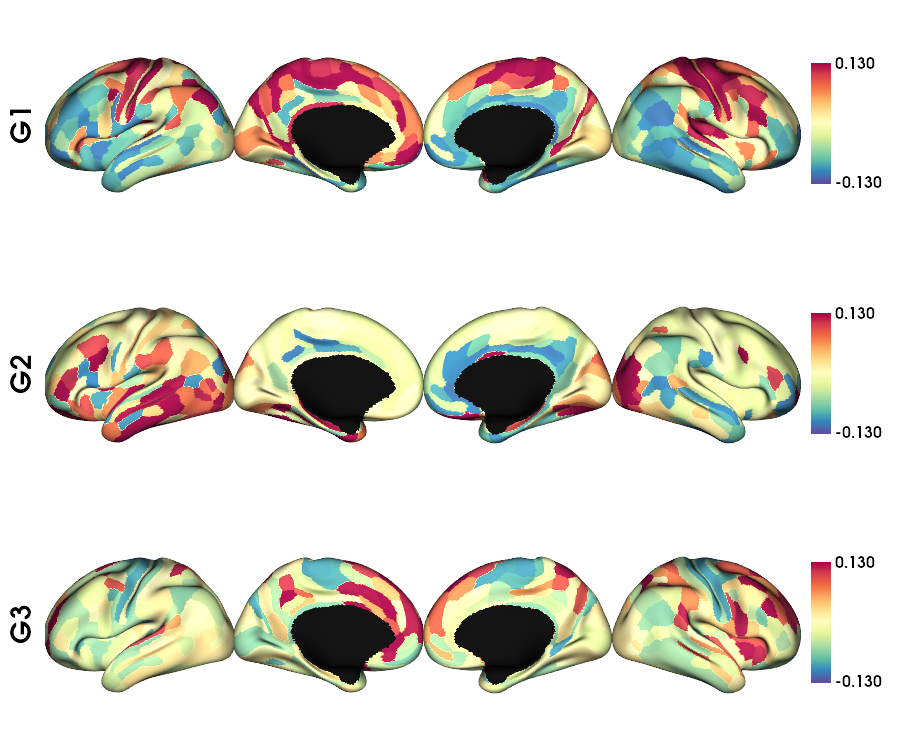

In [124]:
# Map gradients to original parcels
grad = [None] * Ngrads
for i, g in enumerate(MPCdm[:,:,9].T[0:Ngrads,:]):
    grad[i] = map_to_labels(g, labels_c69, fill=np.nan, mask=mask_c69)

# plot the gradients
labels=['G'+str(x) for x in list(range(1,Ngrads+1))]
plot_hemispheres(inf_lh, inf_rh, array_name=grad, cmap='Spectral_r', nan_color=(0, 0, 0, 1),
  zoom=1.3, size=(900, 750), embed_nb=True, color_range=Range,
  color_bar='right', 
  label_text={'left': labels},
  screenshot=False, filename='/home/bic/rcruces/Desktop/MPC_PNA002_'+atlas+'.png') 

In [125]:
from numpy import std, mean, sqrt

#correct if the population S.D. is expected to be equal for the two groups.
def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (mean(x) - mean(y)) / sqrt(((nx-1)*std(x, ddof=1) ** 2 + (ny-1)*std(y, ddof=1) ** 2) / dof)


In [126]:
MPCdm[:,0,indx].shape
MPCdm[:,0,0].shape[0]

360

# Gradients Cohen's D | PX - HC

In [127]:
# Gradient 1 cohen's D
G1_cd = np.array([cohen_d(MPCdm[x,0,~indx], MPCdm[x,0,indx]) for x in range(0,MPCdm[:,0,0].shape[0]) ])
G2_cd = np.array([cohen_d(MPCdm[x,1,~indx], MPCdm[x,1,indx]) for x in range(0,MPCdm[:,0,0].shape[0]) ])
G3_cd = np.array([cohen_d(MPCdm[x,2,~indx], MPCdm[x,2,indx]) for x in range(0,MPCdm[:,0,0].shape[0]) ])


##### 

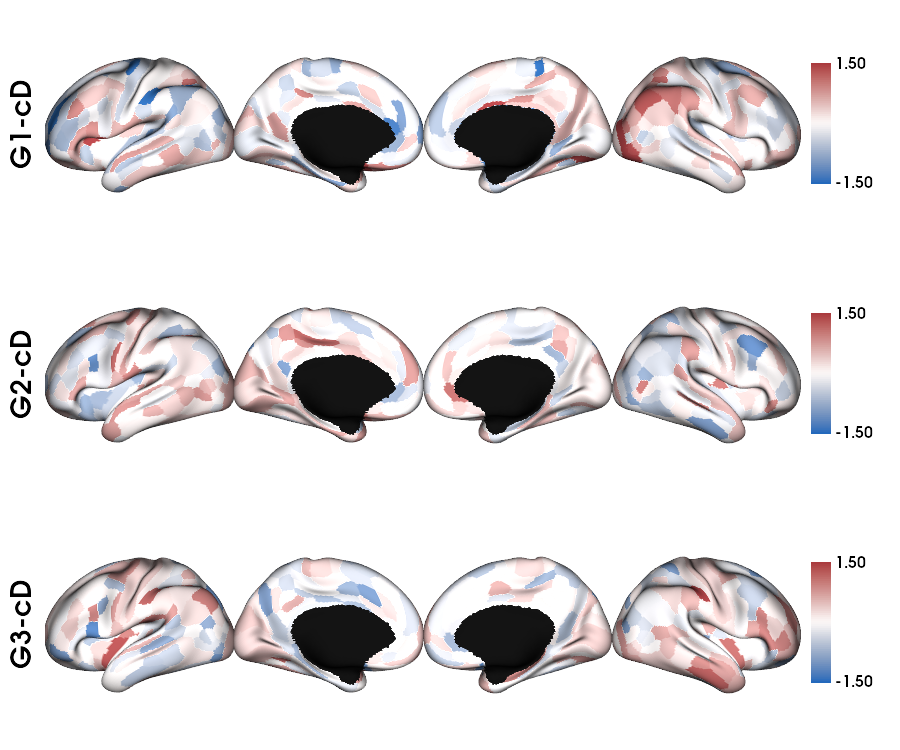

In [128]:
Gcd = [map_to_labels(G1_cd, labels_c69, fill=np.nan, mask=mask_c69), 
       map_to_labels(G2_cd, labels_c69, fill=np.nan, mask=mask_c69), 
       map_to_labels(G3_cd, labels_c69, fill=np.nan, mask=mask_c69)]

# plot the gradients
labels=['G'+str(x)+'-cD' for x in list(range(1,Ngrads+1))]
plot_hemispheres(inf_lh, inf_rh, array_name=Gcd, cmap='vlag', nan_color=(0, 0, 0, 1),
  zoom=1.3, size=(900, 750), embed_nb=True, color_range=(-1.5,1.5),
  color_bar='right', 
  label_text={'left': labels},
  screenshot=False, filename='/home/bic/rcruces/Desktop/MPC_PX-HC_'+atlas+'.png') 

In [136]:
# Plot G1 - group Cohen's D
Gcd[0][np.abs(Gcd[0])<0.75]=0
plot_hemispheres(inf_lh, inf_rh, array_name=smooth_surf(inf_lh, inf_rh,Gcd[0], Niter=10), cmap='coolwarm',
                  embed_nb=True,  label_text={'left':['G1']}, color_bar='right',
                  layout_style='grid',
                  zoom=1.3, size=(900, 750), nan_color=(0, 0, 0, 1), color_range=(-0.8,0.8),
                  screenshot=True, filename='/home/bic/rcruces/Desktop/MPC-G1_cohenD_'+atlas+'.png') 

'/home/bic/rcruces/Desktop/MPC-G1_cohenD_glasser-360.png'

In [57]:
cohen_d([0.8,0.7,0.7,0.6,0.8], [1,1,1,1,0.9])

-3.8758511609996344

array([0.        , 0.        , 0.        , ..., 0.75390618, 0.75390618,
       0.75390618])